<a href="https://colab.research.google.com/github/Maxibrionest/MachineLearning/blob/main/Tarea10-11-21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer


Pasos:
- sacar Y
- determinar 5 variables (podria ser matriz de correlacion)
- justificar variables
- preparar data - MV, normalizacion, estandarizacion, one hot encoder, etc
realizar:
- regresion lineal, training y test sets, metricas
- Lasso, training y test sets, metricas, coef de regresion y cuales fueron consideradas y cuales no
- arbol de regresion, training y test sets, metricas
- comparar y justificar mejor


## seleccion de datos

In [14]:
ls

sample_data/


In [15]:
df_lifeexpectation = pd.read_csv('/gdrive/MyDrive/DuocUC/2021-1/Life Expectancy Data.csv', sep=",")

In [16]:
df_lifeexpectation.sample(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2327,Singapore,2001,Developed,78.7,76.0,0,2.08,1003.366877,95.0,408,28.9,0,95.0,2.37,96.0,0.1,21577.782300,NaN,2.1,2.0,0.820,12.7
1640,Malta,2009,Developed,82.0,63.0,0,7.38,335.518057,86.0,1,67.1,0,73.0,8.33,73.0,0.1,2675.582590,412477.0,0.8,0.7,0.815,14.4
1387,Kiribati,2006,Developing,65.0,212.0,0,0.76,18.194579,88.0,0,72.8,0,86.0,1.93,86.0,0.1,1151.555618,9426.0,0.2,0.1,0.576,12.1
1828,Nepal,2000,Developing,62.5,238.0,46,0.08,17.912337,NaN,9397,11.4,62,74.0,5.43,74.0,0.1,231.425540,2374911.0,18.5,19.2,0.439,8.9
920,Finland,2009,Developing,79.7,91.0,0,9.96,579.738437,NaN,2,59.8,0,99.0,9.20,99.0,0.1,4717.155710,5338871.0,0.9,0.8,0.878,17.0
2348,Slovenia,2012,Developed,82.0,81.0,0,10.95,3283.024864,NaN,2,58.2,0,96.0,9.37,96.0,0.1,22486.471670,257159.0,1.5,1.5,0.877,16.8
763,Djibouti,2005,Developing,58.6,318.0,2,1.23,12.703259,NaN,298,3.2,2,71.0,7.21,71.0,3.9,94.729749,783254.0,5.9,5.8,0.396,4.0
23,Albania,2008,Developing,75.3,1.0,1,5.61,36.622068,99.0,0,52.6,1,99.0,5.87,99.0,0.1,437.539647,2947314.0,1.6,1.6,0.713,12.0
2804,United States of America,2005,Developed,77.5,112.0,28,8.52,0.000000,93.0,66,63.8,33,92.0,15.15,96.0,0.1,NaN,NaN,0.7,0.6,NaN,NaN
2610,Timor-Leste,2006,Developing,64.9,186.0,2,0.04,28.125605,NaN,90,13.9,3,62.0,0.65,63.0,0.1,441.532260,148621.0,11.9,11.9,0.511,11.0


In [23]:
df_lifeexpectation.describe()

,Year,LifeExpentancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [18]:
df_lifeexpectation.shape

(2938, 22)

In [22]:
df_lifeexpectation.type

AttributeError: ignored

In [45]:
df_lifeexpectation = df_lifeexpectation.rename({'Life expectancy ': 'LifeExpectancy', 'Adult Mortality':'AdultMortality', 'Income composition of resources':'IncomeCompositionOfResources'}, axis=1)  # new method


In [46]:
corrdat = df_lifeexpectation.corr()

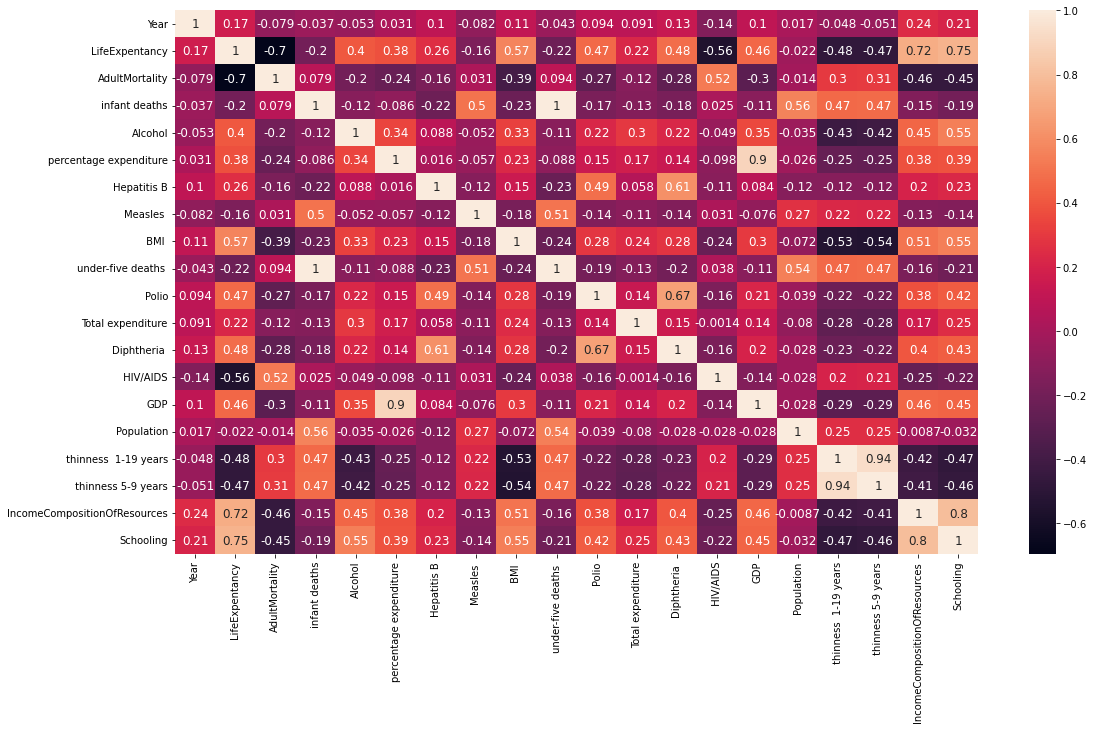

In [47]:
fig , ax = plt.subplots(figsize = (18,10))
sns.heatmap(corrdat , annot = True , annot_kws = {'size':12})

In [48]:
corrdat.columns

Index(['Year', 'LifeExpentancy', 'AdultMortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'IncomeCompositionOfResources', 'Schooling'],
      dtype='object')

In [49]:
def getCorr(dat, lim): #obtiene los features con mayor impacto en el target
    feature = []
    valor = []
    
    for i , index in enumerate(dat.index): #bucle para todos los indices
        if abs(dat[index]) > lim:
            feature.append(index)
            print(index)
            valor.append(dat[index])

    df = pd.DataFrame(data = valor, index = feature, columns = ['corr value'])

    return df

In [50]:
lim = 0.55
corr_value = getCorr(corrdat['LifeExpentancy'], lim)

LifeExpentancy
AdultMortality
 BMI 
 HIV/AIDS
IncomeCompositionOfResources
Schooling


In [51]:
corr_value.sort_values(by=['corr value'])

,corr value
AdultMortality,-0.696359
HIV/AIDS,-0.556556
BMI,0.567694
IncomeCompositionOfResources,0.724776
Schooling,0.751975
LifeExpentancy,1.000000


Con esto se obtiene que las variables que afectan en mayor medida a la esperanza de vida son, en orden segun valor absoluto: 
- Schooling
- Income composition of resources
- Adult Mortality
- BMI
- HIV/AIDS

In [52]:
df_op = df_lifeexpectation[corr_value.index]
df_op.head()

,LifeExpentancy,AdultMortality,BMI,HIV/AIDS,IncomeCompositionOfResources,Schooling
0,65.0,263.0,19.1,0.1,0.479,10.1
1,59.9,271.0,18.6,0.1,0.476,10.0
2,59.9,268.0,18.1,0.1,0.470,9.9
3,59.5,272.0,17.6,0.1,0.463,9.8
4,59.2,275.0,17.2,0.1,0.454,9.5


In [53]:
df_op.shape

(2938, 6)

In [54]:
df_op.type

AttributeError: ignored

In [55]:
X = df_op.drop(['LifeExpentancy'], axis=1)
Y = df_op.LifeExpentancy.copy()

In [56]:
X.head()

,AdultMortality,BMI,HIV/AIDS,IncomeCompositionOfResources,Schooling
0,263.0,19.1,0.1,0.479,10.1
1,271.0,18.6,0.1,0.476,10.0
2,268.0,18.1,0.1,0.470,9.9
3,272.0,17.6,0.1,0.463,9.8
4,275.0,17.2,0.1,0.454,9.5


In [57]:
Y.head()

0    65.0
1    59.9
2    59.9
3    59.5
4    59.2
Name: LifeExpentancy, dtype: float64

## limpieza de datos


In [69]:
df_op.isna().sum()

LifeExpentancy                   10
AdultMortality                   10
 BMI                             34
 HIV/AIDS                         0
IncomeCompositionOfResources    167
Schooling                       163
dtype: int64

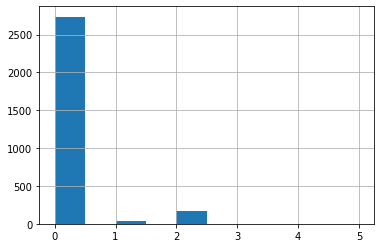

In [70]:
df_op.isna().sum(axis=1).hist()

In [79]:
df_op.isna().sum(axis=1).sort_values(ascending=False)

1715    5
2216    4
1909    4
624     4
1650    3
       ..
1869    0
1868    0
1867    0
1866    0
0       0
Length: 2938, dtype: int64

In [81]:
df_op.iloc[1715]

LifeExpentancy                  NaN
AdultMortality                  NaN
 BMI                            NaN
 HIV/AIDS                       0.1
IncomeCompositionOfResources    NaN
Schooling                       NaN
Name: 1715, dtype: float64

In [93]:
ex = df_op.isna().sum(axis=1).to_frame()
ex = ex.rename({0:'ac'}, axis=1)  # new method
ex

,ac
0,0
1,0
2,0
3,0
4,0
...,...
2933,0
2934,0
2935,0
2936,0


In [104]:
ex[ex.ac > 0].groupby('ac').size()

ac
1     32
2    163
3      3
4      3
5      1
dtype: int64

In [106]:
helper = ex[ex.ac>=3]

In [117]:
lhelper = helper.index.values
lhelper

array([ 624, 1650, 1715, 1812, 1909, 2216, 2713])

In [118]:
ex.drop(lhelper)

,ac
0,0
1,0
2,0
3,0
4,0
...,...
2933,0
2934,0
2935,0
2936,0


In [125]:
df_op.head()

,LifeExpentancy,AdultMortality,BMI,HIV/AIDS,IncomeCompositionOfResources,Schooling
0,65.0,263.0,19.1,0.1,0.479,10.1
1,59.9,271.0,18.6,0.1,0.476,10.0
2,59.9,268.0,18.1,0.1,0.470,9.9
3,59.5,272.0,17.6,0.1,0.463,9.8
4,59.2,275.0,17.2,0.1,0.454,9.5


In [127]:
df_op.LifeExpentancy.notnull()

0       True
1       True
2       True
3       True
4       True
        ... 
2933    True
2934    True
2935    True
2936    True
2937    True
Name: LifeExpentancy, Length: 2931, dtype: bool

In [124]:
#df_op = df_op.drop(lhelper)
df_op = df_op[df_op.LifeExpentancy.notnull()]

AttributeError: ignored

In [ ]:
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
datos_knn[['Primera prueba', 'Segunda prueba']] = knn_imputer.fit_transform(datos_knn[['Primera prueba', 'Segunda prueba']])
datos_knn
